In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

n_epochs = 10
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.001
weight_decay = 0.0001
log_interval = 10

train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=False)

Extracting ./files/MNIST/raw/train-images-idx3-ubyte.gz to ./files/MNIST/raw


Extracting ./files/MNIST/raw/train-labels-idx1-ubyte.gz to ./files/MNIST/raw


Extracting ./files/MNIST/raw/t10k-images-idx3-ubyte.gz to ./files/MNIST/raw


Extracting ./files/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./files/MNIST/raw
Processing...


/u/agoyal/storage/bin/anaconda/envs/cosypose/lib/python3.7/site-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Done!




torch.Size([1000, 1, 28, 28])


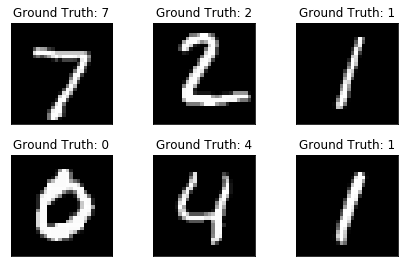

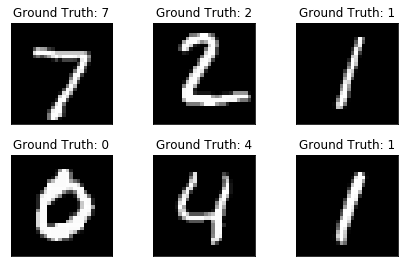

In [2]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
print(example_data.shape)

import matplotlib.pyplot as plt
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        assert x.shape[1:] == torch.Size((1, 28, 28))
        b = x.shape[0]
        x = x.view(b, 28 * 28)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [4]:
network = Net()
network_loss = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(
    network.parameters(), 
    lr=learning_rate, 
    weight_decay=weight_decay)

In [5]:
train_losses = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

def train(epoch):
  network.train()
  train_loss = 0
  correct = 0
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = network_loss(output, target)
    loss.backward()
    optimizer.step()
    
    train_loss += loss.item()
    pred = output.data.max(1, keepdim=True)[1]
    correct += pred.eq(target.data.view_as(pred)).sum()
    
  train_loss /= len(test_loader.dataset)
  train_losses.append(train_loss)
  print('\nTrain set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    train_loss, correct, len(train_loader.dataset),
    100. * correct / len(train_loader.dataset)))
    
    
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += network_loss(output, target).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [6]:
test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()


Test set: Avg. loss: 0.0023, Accuracy: 1077/10000 (11%)


Train set: Avg. loss: 0.0304, Accuracy: 54353/60000 (91%)


Test set: Avg. loss: 0.0002, Accuracy: 9393/10000 (94%)


Train set: Avg. loss: 0.0151, Accuracy: 57164/60000 (95%)


Test set: Avg. loss: 0.0001, Accuracy: 9609/10000 (96%)


Train set: Avg. loss: 0.0111, Accuracy: 57889/60000 (96%)


Test set: Avg. loss: 0.0001, Accuracy: 9653/10000 (97%)


Train set: Avg. loss: 0.0091, Accuracy: 58251/60000 (97%)


Test set: Avg. loss: 0.0001, Accuracy: 9681/10000 (97%)


Train set: Avg. loss: 0.0076, Accuracy: 58502/60000 (98%)


Test set: Avg. loss: 0.0001, Accuracy: 9690/10000 (97%)


Train set: Avg. loss: 0.0066, Accuracy: 58668/60000 (98%)


Test set: Avg. loss: 0.0001, Accuracy: 9702/10000 (97%)


Train set: Avg. loss: 0.0058, Accuracy: 58836/60000 (98%)


Test set: Avg. loss: 0.0001, Accuracy: 9717/10000 (97%)


Train set: Avg. loss: 0.0051, Accuracy: 58958/60000 (98%)


Test set: Avg. loss: 0.0001, Accuracy: 9696/10000 (97%)

In [8]:
weights = {x: y.cpu().numpy() for x,y in network.state_dict().items()} 

import pickle as pkl
with open("weights.pkl", "wb") as file:
    pkl.dump(weights, file)